In [4]:
import tensorflow as tf
import numpy as np

import pandas as pd
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

#import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [23]:
img_width, img_height = 224, 224
LearningRate = 0.001
Decay = 0.000001
batch_size = 16

In [17]:
ResNet = tf.keras.applications.ResNet50(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
# 마지막 prediction layer를 위한 작업

GAP = GlobalAveragePooling2D()(ResNet.output)
predictions = Dense(1, activation='sigmoid')(GAP)

# Input ~ Output 연결해주기
DeepLearning = Model(inputs=ResNet.input, outputs=predictions)

# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='binary_crossentropy',
         metrics=['acc']
) # 나이를, MSE


In [18]:
DeepLearning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [19]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [24]:
# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    'Train',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "binary",
    subset = "training")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    'Test',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode='binary')

Found 266 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


In [25]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='Model/ModelResNet50-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, LR]

In [26]:
########## Training Start
DeepLearning.fit_generator(
        TRAIN_GENERATOR,
        # 데이터가 너무 클 경우 1-epoch을 못하는 경우
        #steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        
        epochs=20,
        callbacks=CALLBACK,
        shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
        validation_data=TEST_GENERATOR)
###########

Epoch 1/20


C:\Users\student\AppData\Local\Temp\ipykernel_2840\1784762658.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  DeepLearning.fit_generator(


17/17 [==============================] - ETA: 0s - loss: 0.4112 - acc: 0.8609
Epoch 1: val_acc improved from -inf to 0.70968, saving model to Model\ModelResNet50-001-0.6210-0.7097.hdf5
17/17 [==============================] - 57s 3s/step - loss: 0.4112 - acc: 0.8609 - val_loss: 0.6210 - val_acc: 0.7097 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.3474 - acc: 0.8910
Epoch 2: val_acc did not improve from 0.70968
17/17 [==============================] - 52s 3s/step - loss: 0.3474 - acc: 0.8910 - val_loss: 0.6330 - val_acc: 0.7097 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.2924 - acc: 0.8985
Epoch 3: val_acc did not improve from 0.70968
17/17 [==============================] - 52s 3s/step - loss: 0.2924 - acc: 0.8985 - val_loss: 0.8679 - val_acc: 0.7097 - lr: 0.0010
Epoch 4/20
17/17 [==============================] - ETA: 0s - loss: 0.2718 - acc: 0.8947
Epoch 4: val_acc did not improve from 0.70968

Epoch 4: Redu

KeyboardInterrupt: 

In [28]:
DeepLearning.load_weights('Model\\ModelResNet50-001-0.6210-0.7097.hdf5')

In [29]:
Pred = DeepLearning.predict( TEST_GENERATOR )

C:\Users\student\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\student\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [30]:
Pred

array([[0.37804365],
       [0.37653953],
       [0.37658492],
       [0.37590182],
       [0.3764921 ],
       [0.37924102],
       [0.38185555],
       [0.38522744],
       [0.38276714],
       [0.3806359 ],
       [0.3801121 ],
       [0.3865716 ],
       [0.38835132],
       [0.38353997],
       [0.38353884],
       [0.3877065 ],
       [0.39135244],
       [0.37726068],
       [0.3726576 ],
       [0.39634472],
       [0.38599163],
       [0.37604982],
       [0.38155928],
       [0.3840394 ],
       [0.3792187 ],
       [0.38755354],
       [0.36399883],
       [0.3632068 ],
       [0.37646   ],
       [0.37882948],
       [0.38020846],
       [0.37801012],
       [0.38409036],
       [0.38451415],
       [0.37604588],
       [0.36930507],
       [0.38366276],
       [0.3831299 ],
       [0.39478552],
       [0.38087523],
       [0.3746218 ],
       [0.3793226 ],
       [0.37995598],
       [0.38016114],
       [0.37498823],
       [0.38189036],
       [0.38194442],
       [0.380

In [32]:
y_test = TEST_GENERATOR.labels

In [33]:
y_pred = Pred

In [37]:
import sklearn

In [39]:
from sklearn import metrics
import matplotlib.pyplot as plt

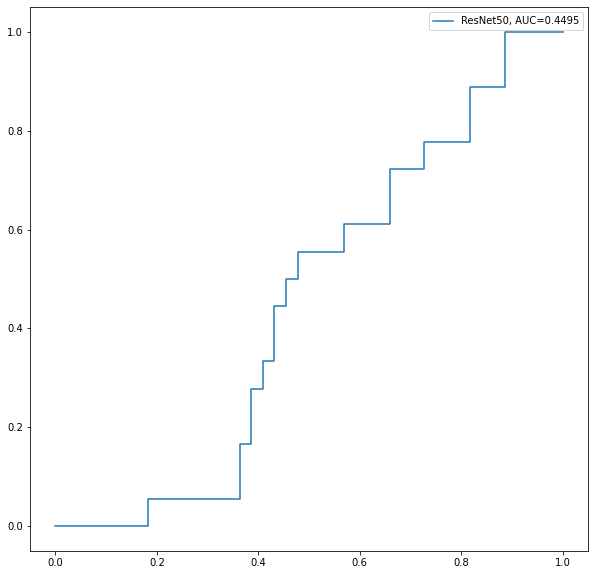

In [40]:
#set up plotting area
plt.figure(figsize=(10,10)).clf()

#fit logistic regression model and plot ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label= "ResNet50, AUC="+str(auc))
    
#fit gradient boosted model and plot ROC curve

#add legend
plt.legend()

In [ ]:
DeepLearning_FeatureExtractor = Model(inputs=ResNet.input, outputs=GAP)

In [ ]:
ExtractedFeatures = DeepLearning_FeatureExtractor.predict( TEST_GENERATOR )